In [137]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.data import (
    chunk_and_tokenize,
    compute_nats_to_bpb_ratio,
    silence_datasets_messages
)


def load_stuff(name):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).cuda()
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-test.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    processed = chunk_and_tokenize(dataset, tokenizer)
    ratio = compute_nats_to_bpb_ratio(dataset, processed)
    return model, tokenizer, processed, ratio

pythia, pythia_tokenizer, pythia_data, pythia_ratio = load_stuff("EleutherAI/pythia-350m-deduped")

In [1]:
import numpy as np


def get_permutation(hidden_states, rate=0.6):
    labels = hidden_states[0][1]  # TODO: Are these really labels?
    labels_length = len(labels)
    permutation = np.random.permutation(range(labels_length)).reshape(-1)
    return [
        permutation[: int(labels_length * rate)],
        permutation[int(labels_length * rate) :],
    ]

In [13]:
PROMPTS = [
    ["Is the moon made of cheese? Yes", "Is the moon made of cheese? No"],
    ["Does the sun rise in the east? Yes", "Does the sun rise in the east? No"],
    ["Does nitrogen have 8 electrons? Yes", "Does nitrogen have 8 electrons? No"],
]

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge-mnli")

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
[choice for choices in PROMPTS for choice in choices]

['Is the moon made of cheese? Yes',
 'Is the moon made of cheese? No',
 'Does the sun rise in the east? Yes',
 'Does the sun rise in the east? No',
 'Does nitrogen have 8 electrons? Yes',
 'Does nitrogen have 8 electrons? No']

In [21]:
import numpy as np

np.array([choice for choices in PROMPTS for choice in choices]).reshape((3, 2))

array([['Is the moon made of cheese? Yes',
        'Is the moon made of cheese? No'],
       ['Does the sun rise in the east? Yes',
        'Does the sun rise in the east? No'],
       ['Does nitrogen have 8 electrons? Yes',
        'Does nitrogen have 8 electrons? No']], dtype='<U35')

In [7]:
train, test = get_permutation(hiddens)

In [8]:
len(train), len(test)

(60, 41)

In [12]:
np.any(train[:, None] == test)

False

In [2]:
from transformers import (
    AutoModelForCausalLM, AutoConfig, PretrainedConfig,
    AutoModelForSeq2SeqLM, AutoModelForSequenceClassification,
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [73]:
from typing import Sequence

def common_prefix_len(a: Sequence, b: Sequence) -> int:
    """Compute the length of the common prefix of two sequences."""
    for i, (x, y) in enumerate(zip(a, b)):
        if x != y:
            return i

    return min(len(a), len(b))

common_prefix_len("hello", "hell")

4

In [1]:
from datasets import load_dataset

counterfact = load_dataset("NeelNanda/counterfact-tracing")

Using custom data configuration NeelNanda--counterfact-tracing-39c4f800d46af5cf
Found cached dataset parquet (/mnt/ssd-1/nora/huggingface/datasets/NeelNanda___parquet/NeelNanda--counterfact-tracing-39c4f800d46af5cf/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
foo = tokenizer([
    'The mother tongue of Danielle Darrieux is',
    'The official religion of Edwin of Northumbria is apiuhrjkgmfqipjnskragbpiqenksf'
], padding=True, return_tensors="pt", return_length=True,
text_target=[
    "hi",
    'hello'
])

In [26]:
foo['input_ids'].gather(
    index=foo['attention_mask'].sum(dim=-1, keepdim=True) - 2, dim=-1
)

tensor([[ 16],
        [506]])

In [5]:
counterfact['train'][1]

{'relation': 'The official religion of {} is',
 'relation_prefix': 'The official religion of',
 'relation_suffix': ' is',
 'prompt': 'The official religion of Edwin of Northumbria is',
 'relation_id': 'P140',
 'target_false_id': 'Q432',
 'target_true_id': 'Q5043',
 'target_true': ' Christianity',
 'target_false': ' Islam',
 'subject': ' Edwin of Northumbria'}

In [79]:
tokenizer.encode("hello </s>world")

[0, 42891, 1437, 2, 8331, 2]

In [1]:
from datasets import load_dataset

data = load_dataset("super_glue", "boolq")
data

Found cached dataset super_glue (/mnt/ssd-1/nora/huggingface/datasets/super_glue/boolq/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})

In [108]:
from promptsource.templates import DatasetTemplates

templates = DatasetTemplates("super_glue", "boolq")
templates.all_template_names

['GPT-3 Style',
 'I wonder…',
 'after_reading',
 'based on the following passage',
 'based on the previous passage',
 'could you tell me…',
 'exam',
 'exercise',
 'valid_binary',
 'yes_no_question']

In [114]:
templates.templates['3e386463-1715-4578-9cba-07d11a0d3b61'].apply(data['train'][0])

['Passage: Persian language -- Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.\n\nAfter reading this passage, I have a question: do iran and afghanistan speak the same language? True or False?',
 'True']

In [95]:
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoModel
config = AutoConfig.from_pretrained("t5-small")
config.architectures

loading configuration file config.json from cache at /mnt/ssd-1/nora/huggingface/transformers/models--t5-small/snapshots/3479082dc36f8a4730936ef1c9b88cd8b0835c53/config.json
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_s

['T5ForConditionalGeneration']

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

In [9]:
tokenizer(["hello"], text_pair=["world, this"])

{'input_ids': [[31373, 6894, 11, 428]], 'attention_mask': [[1, 1, 1, 1]]}

## Resampling

In [ ]:
from tuned_lens import TunedLens
constant = TunedLens.load(
    "/mnt/ssd-1/nora/real-lenses/pythia/125m-deduped/constant-300steps/"
)

In [ ]:
from contextlib import contextmanager
from typing import Generator, Iterable


@contextmanager
def record_nodes(
    model: th.nn.Module,
    selectors: Iterable[str]
) -> Generator[dict[str, th.Tensor], None, None]:
    activations = {}

    def hook_factory(name: str):
        def inner(module, inputs, outputs):
            x, *_ = inputs
            activations[name] = x

        return inner

    handles = []
    queries = set(selectors)
    for name, module in model.named_modules():
        if name in queries:
            handles.append(
                module.register_forward_hook(hook_factory(name))
            )
            queries.remove(name)

    try:
        yield activations
    finally:
        for handle in handles:
            handle.remove()

In [1]:
import torch as th


root = "/mnt/ssd-1/nora/tuned-lenses/pythia/12b-deduped/"
vanilla_transfer = th.load(
    root + "affine/eval/aggregate_transfer_metrics.pt", map_location="cpu"
)
vanilla = th.load(
    root + "affine/eval/aggregate_metrics.pt", map_location="cpu"
)

In [ ]:
import plotly.graph_objects as go

x, y = vanilla_transfer['transfer_ce'].shape
fig = go.Figure(
    go.Surface(
        x=th.arange(x),
        y=th.arange(y),
        z=(vanilla_transfer['transfer_ce'] - vanilla_transfer['transfer_ce'].diag()).T,
    )
).update_layout(
    title="GPT-NeoX 20B Transfer Excess CE"
).update_scenes(
    xaxis_title_text="Train Layer",
    yaxis_title_text="Test Layer",
    zaxis_title_text="bits per byte"
)
fig

In [ ]:
from tuned_lens import TunedLens

lens = TunedLens.load("/mnt/ssd-1/nora/real-lenses/pythia/125m-deduped/affine/")

TunedLens.load: ignoring config key 'sublayers'
TunedLens.load: ignoring config key 'identity_init'
TunedLens.load: ignoring config key 'dropout'
TunedLens.load: ignoring config key 'shared_mlp_hidden_sizes'
TunedLens.load: ignoring config key 'mlp_hidden_sizes'
TunedLens.load: ignoring config key 'rank'


Text(0.5, 1.0, 'GPT Neo X 20B Tuned Lens Transfer Excess CE')

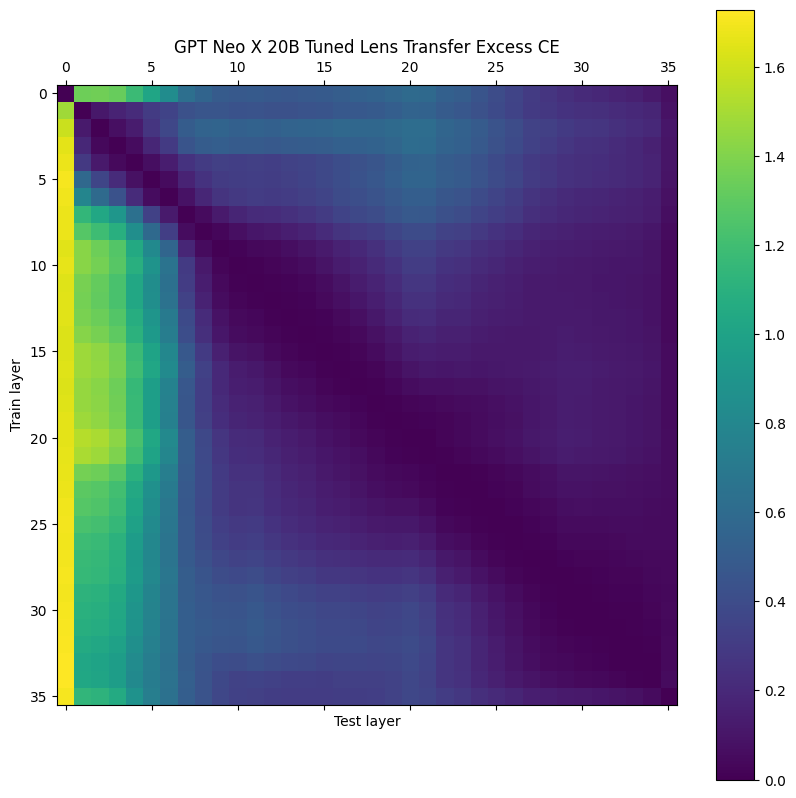

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.matshow(
    vanilla_transfer['transfer_ce'] - vanilla_transfer['transfer_ce'].diag(),
    fignum=0
)
plt.colorbar()
plt.xlabel("Test layer")
plt.ylabel("Train layer")
plt.title("GPT Neo X 20B Tuned Lens Transfer Excess CE")

In [ ]:
from tuned_lens import ResidualStats
import torch as th

stats = th.load(
    "/mnt/ssd-1/nora/real-lenses/pythia/13b-deduped/affine/eval/stream_stats.pt",
    map_location="cpu"
)

In [ ]:
covmats = th.stack(list(stats.covariance()))
covs = covmats.flatten(1)

In [ ]:
L, Q = th.linalg.eigh(covmats)
trimmed_L = L.clone()
trimmed_L[:, -2:] = 0
trimmed_covmats = Q @ th.diag_embed(trimmed_L) @ Q.mT
trimmed_covs = trimmed_covmats.flatten(1)

def frobenius_similarities(A):
    A = A.flatten(1)
    gram = A @ A.T
    norms = A.norm(dim=-1, keepdim=True)

    return gram / (norms * norms.T)

In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.05,
    # shared_yaxes=True,
    subplot_titles=("all principal components", "w/o top 2 components"),
    x_title="Layer",
    y_title="Layer"
).add_trace(
    go.Heatmap(
        z=frobenius_similarities(covs).cpu(),
        coloraxis="coloraxis"
    ),
    row=1, col=1
).add_trace(
    go.Heatmap(
        z=frobenius_similarities(trimmed_covs).cpu(),
        coloraxis="coloraxis"
    ),
    row=1, col=2
).update_layout(
    coloraxis_colorbar=dict(
        title=dict(
            side="right",
            text="Cosine similarity (Frobenius)",
        )
    ),
    title="Similarity of covariance across depth (Pythia 12B)"
).update_xaxes(
    dtick=5
).update_yaxes(
    dtick=5,
)
fig

NameError: name 'frobenius_similarities' is not defined

In [14]:
import plotly.express as px

COL_WIDTH = 6.75 * 96

fig = px.imshow(
    vanilla_transfer['transfer_ce'] - vanilla_transfer['transfer_ce'].diag(),
    # color_continuous_scale=px.colors.sequential.Oranges_r,
).update_coloraxes(
    colorbar_title=dict(
        side="right",
        text="bits per byte",
    )
).update_xaxes(
    dtick=5,
    title="Test layer"
).update_yaxes(
    dtick=5,
    title="Train layer"
).update_layout(
    font=dict(size=16, color="black"),
    margin_l=70,
    margin_r=30,
    margin_t=50,
    margin_b=70,
    height=COL_WIDTH * 0.9,
    width=COL_WIDTH,
)
fig

In [ ]:
fig.write_image("/mnt/ssd-1/nora/transfer-penalties.pdf")

Text(0.5, 1.0, 'GPT Neo X 20B Tuned Lens Transfer CE')

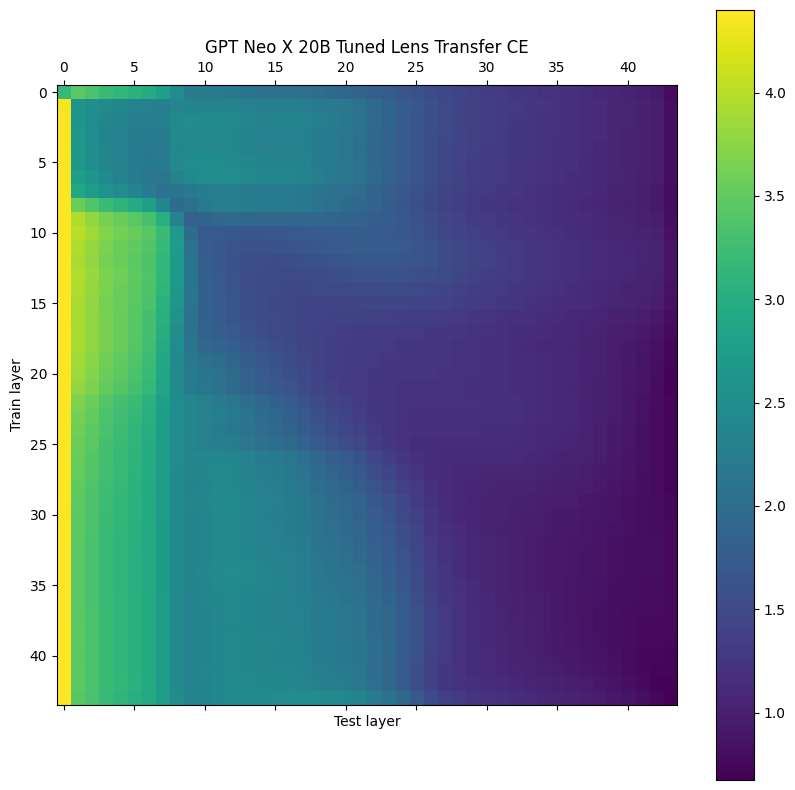

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.matshow(vanilla_transfer['transfer_ce'], fignum=0)
plt.colorbar()
plt.xlabel("Test layer")
plt.ylabel("Train layer")
plt.title("GPT Neo X 20B Tuned Lens Transfer CE")

Text(0, 0.5, 'bits per byte')

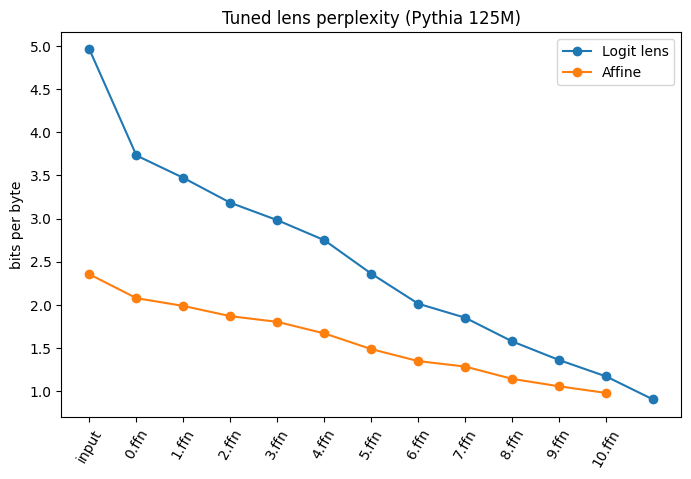

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(vanilla["baseline_ce"].values(), label="Logit lens", marker='o')
plt.plot(vanilla["lens_ce"].values(), label="Affine", marker='o')
# plt.plot(mlp["lens_ce"].values(), label="MLP", marker='o')
plt.legend()
plt.title("Tuned lens perplexity (Pythia 125M)")
plt.xticks(range(len(vanilla["lens_ce"])), vanilla["lens_ce"].keys(), rotation=60)
plt.ylabel("bits per byte")

Text(0, 0.5, 'bits per byte')

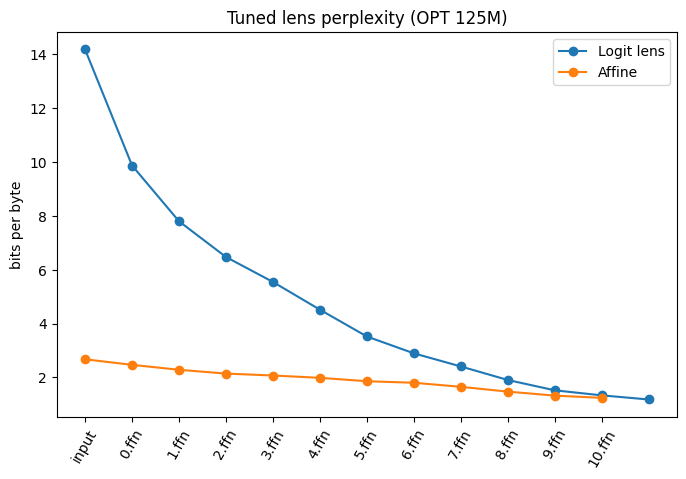

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(vanilla["baseline_ce"].values(), label="Logit lens", marker='o')
plt.plot(vanilla["lens_ce"].values(), label="Affine", marker='o')
# plt.plot(mlp["lens_ce"].values(), label="MLP", marker='o')
plt.legend()
plt.title("Tuned lens perplexity (OPT 125M)")
plt.xticks(range(len(vanilla["lens_ce"])), vanilla["lens_ce"].keys(), rotation=60)
plt.ylabel("bits per byte")

Text(0, 0.5, 'bits per byte')

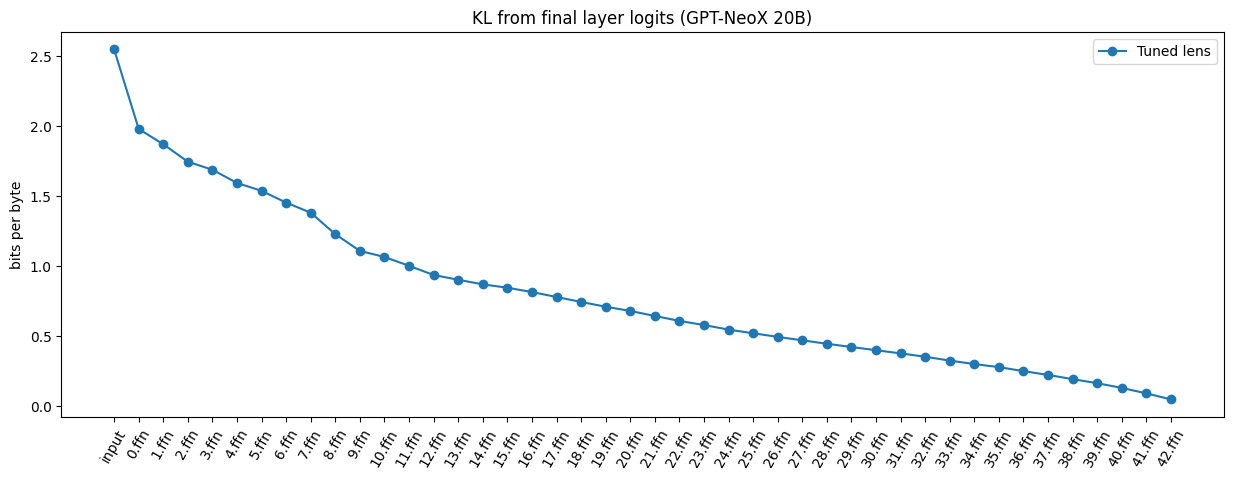

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(vanilla["lens_kl"].values(), label="Tuned lens", marker='o')
plt.legend()
plt.title("KL from final layer logits (GPT-NeoX 20B)")
plt.xticks(range(len(vanilla["lens_kl"])), vanilla["lens_kl"].keys(), rotation=60)
plt.ylabel("bits per byte")

In [ ]:
import chart_studio.plotly as py

py.plot(fig, filename="gpt-neox-transfer-surface", auto_open=True)

'https://plotly.com/~norabelrose/20/'

In [ ]:
import torch as th

stats = th.load(
    "/mnt/ssd-1/nora/real-lenses/pythia/125m-deduped/affine/eval/stream_stats.pt",
    map_location="cpu"
)
stats_sd = th.load(
    "/mnt/ssd-1/nora/real-lenses/pythia/125m-stochastic-depth/eval/stream_stats.pt",
    map_location="cpu"
)

In [ ]:
from tuned_lens.stats import effective_rank

ranks = stats.covariance().map(lambda x: effective_rank(x, num_rogue_dims=1))
# ranks_sd = stats_sd.covariance().map(lambda x: effective_rank(x))

In [ ]:
stats.covariance().map(lambda x: th.linalg.svdvals(x)[:5])

ResidualStream(embeddings=tensor([0.0128, 0.0122, 0.0114, 0.0097, 0.0080]), attentions=[], layers=[tensor([6.5772, 2.3674, 1.6174, 0.8219, 0.7915]), tensor([6.0471, 4.3783, 2.9650, 1.3038, 1.0795]), tensor([11.6577,  4.6821,  3.5539,  2.7573,  1.6708]), tensor([144.0221,   5.3801,   4.3650,   2.9148,   2.3916]), tensor([166.3919,   5.4883,   4.5562,   3.3905,   2.2782]), tensor([171.6418,   7.0210,   4.5639,   3.6023,   2.5606]), tensor([175.5272,  14.1427,   9.0913,   4.4696,   3.7037]), tensor([176.7589,  30.8698,   7.7206,   7.2474,   4.1046]), tensor([169.9944,  45.7058,  15.6314,   9.9243,   5.3007]), tensor([147.2540,  65.9325,  23.6067,  12.0857,   7.4272]), tensor([83.5916, 52.2491, 24.4546, 16.6922, 12.0941]), tensor([105.8006, 100.0112,  24.4255,  19.2456,  18.0495])])

In [ ]:
def rogue_dim_score(x):
    vals = th.linalg.svdvals(x)
    return vals[0] - vals[1]

stats.covariance().map(rogue_dim_score)

ResidualStream(embeddings=tensor(0.0006), attentions=[], layers=[tensor(4.2098), tensor(1.6688), tensor(6.9757), tensor(138.6420), tensor(160.9036), tensor(164.6207), tensor(161.3845), tensor(145.8890), tensor(124.2887), tensor(81.3215), tensor(31.3425), tensor(5.7894)])

(0.0, 768.0)

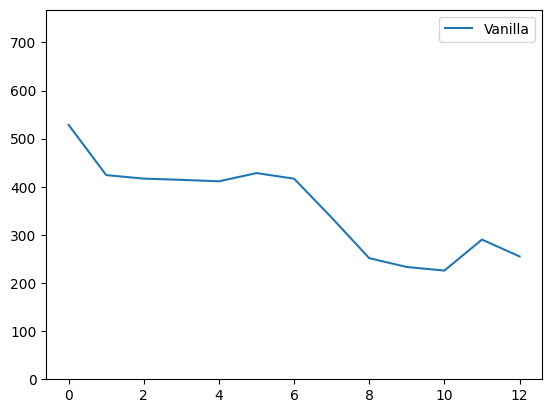

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ranks, label="Vanilla")
# plt.plot(ranks_sd, label="Stochastic depth")
plt.legend()
plt.ylim(0, 768)